## 0. Import libraries

In [2]:
# basic libs
import os
import numpy as np
import datetime

# data processing libs
import rasterio as rio
import xarray as xr
import rioxarray
import json
import requests
from pyproj import CRS
from osgeo import gdal
from math import ceil, floor

# plotting libs
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from odc.stac import stac_load
import planetary_computer
import pystac_client
import rich.table

input_path = r"G:\Shared drives\Ryoko and Hilary\SMSigxSMAP\analysis\1_data"
SMAPL3_path = r".\SPL3SMP_E"
SMAPL4_path = r".\SPL4SMGP"
MODIS_path = r".\MOD15A2H"

## 1. Get EASE grid

In [3]:
fn = "SMAP_L4_SM_lmc_00000000T000000_Vv7032_001.h5"

file_path = os.path.join(input_path, SMAPL4_path, fn)
if os.path.exists(file_path):
    print('The file exists')

g = gdal.Open(file_path)
subdatasets = g.GetSubDatasets()

varname_lat = "cell_lat"
full_varname_lat = f'HDF5:"{file_path}"://{varname_lat}'

varname_lon = "cell_lon"
full_varname_lon = f'HDF5:"{file_path}"://{varname_lon}'

varname_ease_column = "cell_column"
full_varname_ease_column = f'HDF5:"{file_path}"://{varname_ease_column}'

varname_ease_row = "cell_row"
full_varname_ease_row = f'HDF5:"{file_path}"://{varname_ease_row}'

lat = rioxarray.open_rasterio(full_varname_lat)
lon = rioxarray.open_rasterio(full_varname_lon)
ease_column = rioxarray.open_rasterio(full_varname_ease_column)
ease_row = rioxarray.open_rasterio(full_varname_ease_row)


The file exists


c:\Users\flipl\anaconda3\envs\SMAP\lib\site-packages\rioxarray\_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
c:\Users\flipl\anaconda3\envs\SMAP\lib\site-packages\rioxarray\_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
c:\Users\flipl\anaconda3\envs\SMAP\lib\site-packages\rioxarray\_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
c:\Users\flipl\anaconda3\envs\SMAP\lib\site-packages\rioxarray\_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.wa

In [4]:
target_lat = -35.32395
target_lon = 147.5348

distance = np.sqrt((target_lat-lat[0].values)**2+(target_lon-lon[0].values)**2)

minElement  = np.where(abs(distance) == np.nanmin(abs(distance)))
print(np.nanmin(distance))

if len(minElement[0])!=1:
    print('There are more than two closest cells')
    
lat_center = lat[0].values[minElement]
lon_center = lon[0].values[minElement]
ease_center_column = ease_column[0].values[minElement]
ease_center_row = ease_row[0].values[minElement]

print(f'The closest cell to the point ({target_lat}, {target_lon}) is\
      ({lat_center[0]}, {lon_center[0]}:\
      EASE GRID ({ease_center_row[0]}, {ease_center_column[0]})),\
      d={distance[minElement]} degrees')mo

bbox_lat_min = (lat[0].values[minElement]+lat[0].values[minElement[0][0]+1][minElement[1][0]])/2
bbox_lat_max = (lat[0].values[minElement]+lat[0].values[minElement[0][0]-1][minElement[1][0]])/2
bbox_lon_max = (lon[0].values[minElement]+lon[0].values[minElement[0][0]][minElement[1][0]+1])/2
bbox_lon_min = (lon[0].values[minElement]+lon[0].values[minElement[0][0]][minElement[1][0]-1])/2

bounding_box = f'{bbox_lon_min[0]},{bbox_lat_min[0]},{bbox_lon_max[0]},{bbox_lat_max[0]}'
print(bounding_box)


0.038834024
The closest cell to the point (-35.32395, 147.5348) is      (-35.29212188720703, 147.5570526123047:      EASE GRID (1281, 3508)),      d=[0.03883402] degrees
147.5103759765625,-35.335205078125,147.60372924804688,-35.24908447265625


## 2. GET corresponding SMAP L3 data 

### Get granule

In [6]:
# https://docs.xarray.dev/en/stable/user-guide/data-structures.html
# latitude: Latitude of the center of a 9 km EASE-Grid  2.0 cell.

my_credential_path = "../0_code/auth.json"
with open(my_credential_path, 'r') as infile:
    my_credentials = json.load(infile)
    
uid = my_credentials['username'] # Enter Earthdata Login user name
pswd = my_credentials['password'] # Enter Earthdata Login password
email = my_credentials['email'] # Enter Earthdata login email 

In [8]:
short_name = 'SPL3SMP_E'
params = {
    'short_name': short_name
}

cmr_collections_url = 'https://cmr.earthdata.nasa.gov/search/collections.json'
response = requests.get(cmr_collections_url, params=params)
results = json.loads(response.content)

versions = [el['version_id'] for el in results['feed']['entry']]
latest_version = max(versions)
print('The most recent version of ', short_name, ' is ', latest_version)

 #input('Input spatial coordinates in the following order: lower left longitude,lower left latitude,upper right longitude,upper right latitude. Leave blank if you wish to provide a vector-based spatial file for ICESat-2 search and subsetting:')
start_date = '2015-03-31'# input('Input start date in yyyy-MM-dd format: ')
start_time = '00:00:00' # input('Input start time in HH:mm:ss format: ')
end_date = '2016-03-30' # input('Input end date in yyyy-MM-dd format: ')
end_time = '00:00:00' # input('Input end time in HH:mm:ss format: ')


The most recent version of  SPL3SMP_E  is  005


In [9]:
temporal = start_date + 'T' + start_time + 'Z' + ',' + end_date + 'T' + end_time + 'Z'
granule_search_url = 'https://cmr.earthdata.nasa.gov/search/granules'
aoi='1'
if aoi == '1':
# bounding box input:
    search_params = {
    'short_name': short_name,
    'version': latest_version,
    'temporal': temporal,
    'page_size': 100,
    'page_num': 1,
    'bounding_box': bounding_box
    }

granules = []
headers={'Accept': 'application/json'}
while True:
    response = requests.get(granule_search_url, params=search_params, headers=headers)
    results = json.loads(response.content)

    if len(results['feed']['entry']) == 0:
        # Out of results, so break out of loop
        break

    # Collect results and increment page_num
    granules.extend(results['feed']['entry'])
    search_params['page_num'] += 1

print('There are', len(granules), 'granules of', short_name, 'version', latest_version, 'over my area and time of interest.')

There are 364 granules of SPL3SMP_E version 005 over my area and time of interest.


### Read the data 

The file exists


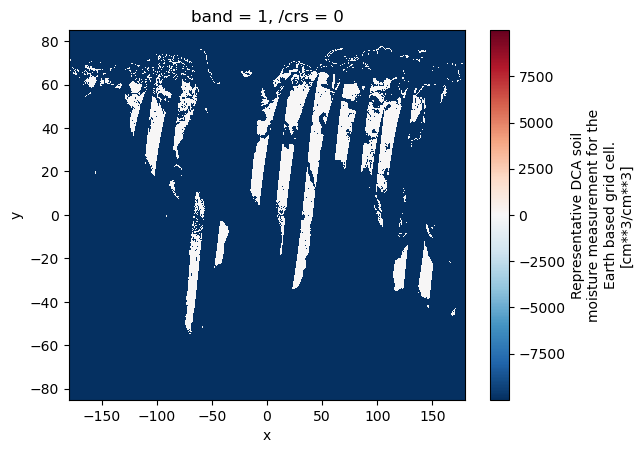

In [9]:
# i = 55
fn ='SMAP_L3_SM_P_E_20191021_R18290_001_HEGOUT.nc'
# TODO: redownload the data with latitude_pm and longitude_pm, also easegrid_(column, row)_pm and easegrid_(column, row)_am 
file_path = os.path.join(input_path, SMAPL3_path, fn)
if os.path.exists(file_path):
    print('The file exists')
else:
    print(f"The file {file_path} doesn't exist")

SMAPL3 = rioxarray.open_rasterio(file_path)
# print(SMAPL3.rio.crs)
samplePoint_SMAP = SMAPL3.rio.clip_box(
    minx=bbox_lon_min,
    miny=bbox_lat_min,
    maxx=bbox_lon_max,
    maxy=bbox_lat_max,
    crs="EPSG:4326",
    auto_expand_limit = 1
).copy()

# SMAPL3.soil_moisture.plot()
    

In [11]:
print(samplePoint_SMAP.x.values)
print(samplePoint_SMAP.y.values)
# 147.5103759765625,-35.335205078125,147.60372924804688,-35.24908447265625

[147.55704555 147.65040654]
[-35.25113781 -35.34449881]


## 3. Get MODIS data

### 3.1. Read catalog of MODIS data

In [24]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)


def float_round(num, places = 0, direction = floor):
    return direction(num * (10**places)) / float(10**places)

buffer=0.5
bbox = [bbox_lon_min[0]-buffer, bbox_lat_min[0]-buffer, bbox_lon_max[0]+buffer, bbox_lat_max[0]+buffer]
bbox = [float_round(x, 10, round)for x in bbox] 
print(bbox)
year = "2019"
months = {
    "February": "2",
}

time_range = "2019-03-01/2019-03-31"

search = catalog.search(
    collections=["modis-15A3H-061"],
    bbox=bbox,
    datetime=time_range,
)
items = list(search.get_items())
print(f"Found: {len(items):d} datasets")

items_dict = dict()
for i, item in enumerate(items):
    items_dict[i] = item
print(items_dict.values())

# t = rich.table.Table("Key", "Title")
# for key, asset in items[0].assets.items():
#     t.add_row(key, asset.title)
# t

[147.0103759766, -35.8352050781, 148.103729248, -34.7490844727]
Found: 18 datasets
dict_values([<Item id=MCD15A3H.A2019089.h30v12.061.2020291110525>, <Item id=MCD15A3H.A2019089.h29v12.061.2020291110529>, <Item id=MCD15A3H.A2019085.h30v12.061.2020291072312>, <Item id=MCD15A3H.A2019085.h29v12.061.2020291072317>, <Item id=MCD15A3H.A2019081.h30v12.061.2020291024923>, <Item id=MCD15A3H.A2019081.h29v12.061.2020291024426>, <Item id=MCD15A3H.A2019077.h30v12.061.2020290202643>, <Item id=MCD15A3H.A2019077.h29v12.061.2020290202651>, <Item id=MCD15A3H.A2019073.h30v12.061.2020289180124>, <Item id=MCD15A3H.A2019073.h29v12.061.2020289180352>, <Item id=MCD15A3H.A2019069.h30v12.061.2020289150708>, <Item id=MCD15A3H.A2019069.h29v12.061.2020289150040>, <Item id=MCD15A3H.A2019065.h30v12.061.2020289102700>, <Item id=MCD15A3H.A2019065.h29v12.061.2020289102705>, <Item id=MCD15A3H.A2019061.h30v12.061.2020289024418>, <Item id=MCD15A3H.A2019061.h29v12.061.2020289024423>, <Item id=MCD15A3H.A2019057.h30v12.061.20

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key              ┃ Title                                             ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ hdf              │ Source data containing all bands                  │
│ Lai_500m         │ Leaf Area Index                                   │
│ metadata         │ Federal Geographic Data Committee (FGDC) Metadata │
│ Fpar_500m        │ Fraction of Photosynthetically Active Radiation   │
│ FparLai_QC       │ Quality for FPAR and LAI                          │
│ FparExtra_QC     │ Extra detail Quality for FPAR and LAI             │
│ LaiStdDev_500m   │ Standard deviation of LAI                         │
│ FparStdDev_500m  │ Standard deviation of FPAR                        │
│ tilejson         │ TileJSON with default rendering                   │
│ rendered_preview │ Rendered preview                                  │
└──────────────────┴───────────────────────────────────────────────────┘

### Get the MODIS composite for a day, and resample to SMAP data

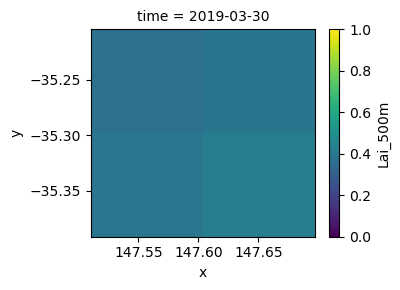

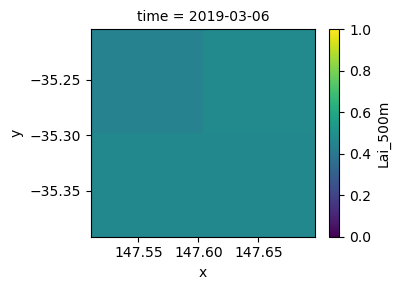

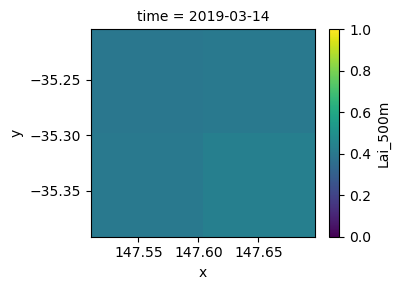

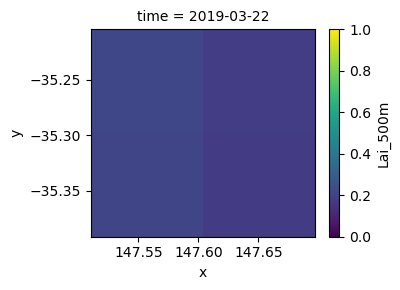

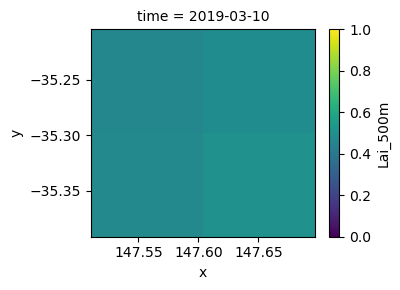

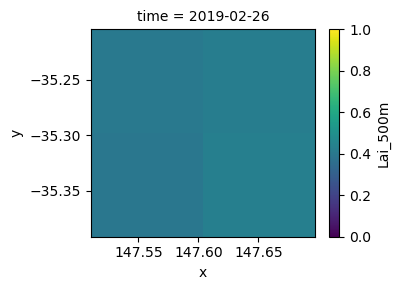

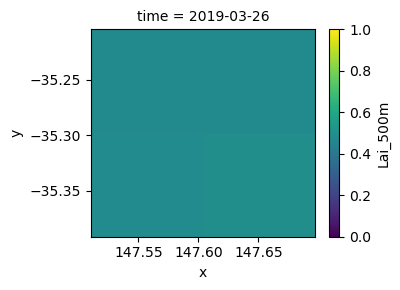

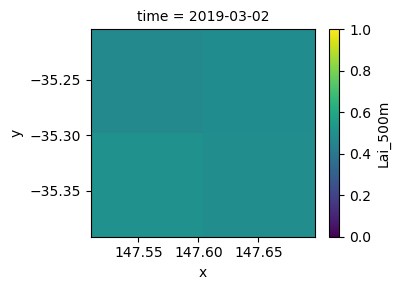

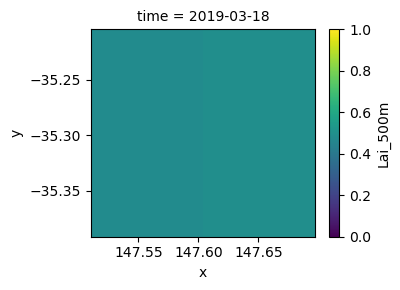

In [106]:
# Get the unique dates from the list of items 
unique_dates = []
for i in range(len(items)):
    split_itemid = str(items[i]).split(".")
    unique_dates.append(split_itemid[1])
unique_dates = set(unique_dates)

# Iterate through the unique dates 
for i, unique_date in enumerate(unique_dates):
    item_for_the_unique_date = []
    
    # Create a paired list of granules for the unique date
    for j, item in enumerate(items):
        if (unique_date in str(item)): 
            item_for_the_unique_date.append(item)
    
    # Iterate through the list of granules for the unique date 
    for k, item in enumerate(item_for_the_unique_date):
        
        # Read MODIS data from STAC server
        MODIS_data0 = stac_load(
            [item],
            crs="EPSG:4326",
            bands="Lai_500m",
            resolution=0.0045,
            bbox=bbox
        )
        
        # Scale the data 
        raster = item.assets["Lai_500m"].extra_fields["raster:bands"]
        MODIS_data = MODIS_data0["Lai_500m"] * raster[0]["scale"]
        MODIS_data.values[MODIS_data.values >=24.9] = np.nan

        # Merge the data 
        if k==0:
            MODIS_dataset = MODIS_data
        else:
            MODIS_dataset = MODIS_dataset.combine_first(MODIS_data)
        
        # Resample to SMAP grid cells 
        if k==len(item_for_the_unique_date)-1:
            MODIS_dataset = MODIS_dataset.rename({'longitude': 'x', 'latitude': 'y'})
            MODIS_dataset_clipped = MODIS_dataset.rio.clip_box(minx=min(samplePoint_SMAP.x).values, miny=min(samplePoint_SMAP.y).values, maxx=max(samplePoint_SMAP.x).values, maxy=max(samplePoint_SMAP.y).values)
            # MODIS_dataset_clipped.plot.imshow(cmap="viridis", col="time", vmin=0, vmax=1)
            # xr.plot.hist(MODIS_dataset_clipped)
            MODIS_dataset_resampled_to_SMAP = MODIS_dataset.rio.reproject_match(samplePoint_SMAP, resampling=rio.enums.Resampling.average)
            # cubic resampling might be more accurate, but ends up in nan values 
            MODIS_dataset_resampled_to_SMAP.plot.imshow(cmap="viridis", col="time", vmin=0, vmax=1)
            
            if i==0:
                MODIS_TSdataset_resampled_to_SMAP = MODIS_dataset_resampled_to_SMAP
            else:
                MODIS_TSdataset_resampled_to_SMAP = xr.concat([MODIS_TSdataset_resampled_to_SMAP, MODIS_dataset_resampled_to_SMAP], dim="time")

### Get the timeseries of a cell

In [6]:
MODIS_TSdataset_resampled_to_SMAP = MODIS_TSdataset_resampled_to_SMAP.sortby("time")

MODIS1d = MODIS_TSdataset_resampled_to_SMAP.isel(x=0, y=0)
MODIS1d.plot()

print(MODIS_TSdataset_resampled_to_SMAP.time)

NameError: name 'MODIS_TSdataset_resampled_to_SMAP' is not defined

## Read SMAP L4 data

In [14]:
# i = 55
fn ='SMAP_L4_SM_gph_20150531T163000_Vv6032_001_HEGOUT.nc'
# TODO: redownload the data with latitude_pm and longitude_pm, also easegrid_(column, row)_pm and easegrid_(column, row)_am 
file_path = os.path.join(input_path, SMAPL4_path, fn)
if os.path.exists(file_path):
    print('The file exists')
else:
    print(f"The file {file_path} doesn't exist")

SMAPL4 = rioxarray.open_rasterio(file_path)
# SMAPL4.precipitation_total_surface_flux[0].values = np.flipud(SMAPL4.precipitation_total_surface_flux[0].values)
# Somehow y axis of SMAP L4 data is flipped ... 
ds2 = xr.DataArray(
                data=np.flipud(SMAPL4.precipitation_total_surface_flux[0].values),  # already in meter
                dims=['y', 'x'],
                coords={
                    'y': SMAPL4.y.values,
                    'x': SMAPL4.x.values
                },
                attrs={'_FillValue': np.nan}
            )
ds2.rio.write_crs("EPSG:4326", inplace=True)
ds2.values[ds2.values == -9999] = np.nan
samplePoint_SMAPL4 = ds2.rio.clip_box(
    minx=bbox_lon_min,
    miny=bbox_lat_min,
    maxx=bbox_lon_max,
    maxy=bbox_lat_max,
    crs="EPSG:4326",
    auto_expand_limit = 1
).copy()
# samplePoint_SMAPL4.plot()
# SMAPL4.precipitation_total_surface_flux.plot()
# ds2.plot()

The file exists


c:\Users\flipl\anaconda3\envs\SMAP\lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
c:\Users\flipl\anaconda3\envs\SMAP\lib\site-packages\rioxarray\_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


## Resample SMAP L4 data 

## Plot SMAP L4 data

In [2]:
## 

## Repeat the analysis to get the timeseries of data (probably rewrite to python code)

## Get Ltheta with LAI 